## Классификатор текстов

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Импортируем все необходимые библиотеки для работы.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import random
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Загрузка данных

In [4]:
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

In [5]:
#Model
BATCH_SIZE = 128
EPOCH = 15
VAL_SPLIT = 0.2

# TOKENIZER
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 150

#### TRAIN

In [13]:
df_train  = pd.read_csv("./drive/My Drive/Genre Classification Dataset/train_data.txt", sep=" ::: ", header=None)
df_train .columns = ["id", "title", "genre", "description"]
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


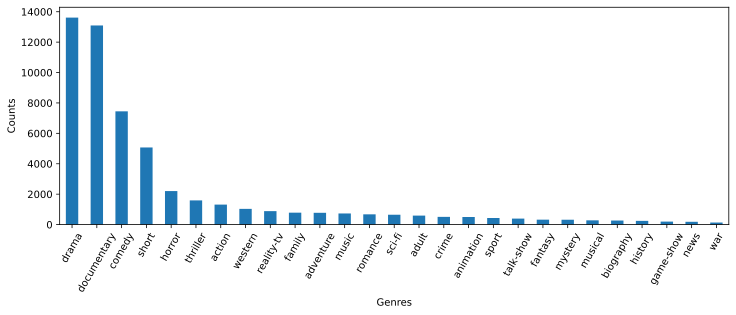

In [15]:
df_train.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)
plt.show()

### TEST

In [25]:
df_test = pd.read_csv("./drive/My Drive/Genre Classification Dataset/test_data_solution.txt", sep=" ::: ", header=None)
df_test.columns = ["id", "title", "genre", "description"]
df_test.head()

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


### Target

In [26]:
Y = pd.get_dummies(df_train.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [27]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game-show,history,horror,music,musical,mystery,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Предварительная обработка

In [29]:
# для построения словаря мы используем весь текст
all_text = df_train.description.append(df_test.description, ignore_index=True)


In [30]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)


CPU times: user 10.3 s, sys: 47.2 ms, total: 10.3 s
Wall time: 10.3 s


In [31]:
#теперь переведем наш текст в вектор
sequences = tokenize.texts_to_sequences(df_train.description)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix.shape)

(54214, 150)


In [34]:
print(df_train.description[1])
print(sequences_matrix[1])

A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     3   194
     2   255     9     3   162 13276   201    41     3   906  4142   201
    11  1493 

# Модель


In [35]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [36]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               25856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 27)                6939      
Total params: 1,093,195
Trainable params: 1,

In [37]:
history = model.fit(sequences_matrix,Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_split=VAL_SPLIT)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 43371 samples, validate on 10843 samples
Epoch 1/15
43371/43371 [==============================] - 75s 2ms/step - loss: 2.4340 - accuracy: 0.2477 - val_loss: 2.3345 - val_accuracy: 0.2521
Epoch 2/15
43371/43371 [==============================] - 73s 2ms/step - loss: 2.2003 - accuracy: 0.2561 - val_loss: 2.1038 - val_accuracy: 0.2596
Epoch 3/15
43371/43371 [==============================] - 73s 2ms/step - loss: 1.8425 - accuracy: 0.4016 - val_loss: 1.8248 - val_accuracy: 0.4533
Epoch 4/15
43371/43371 [==============================] - 73s 2ms/step - loss: 1.6226 - accuracy: 0.4938 - val_loss: 1.8084 - val_accuracy: 0.4662
Epoch 5/15
43371/43371 [==============================] - 73s 2ms/step - loss: 1.4694 - accuracy: 0.5397 - val_loss: 1.7824 - val_accuracy: 0.5095
Epoch 6/15
43371/43371 [==============================] - 72s 2ms/step - loss: 1.2914 - accuracy: 0.6060 - val_loss: 1.8

In [58]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
    plt.style.use('seaborn-white')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    plt.title("Training and validation accuracy")
    plt.legend()
    
    
    plt.figure(figsize = (10,5))
    plt.style.use('seaborn-white')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.show()

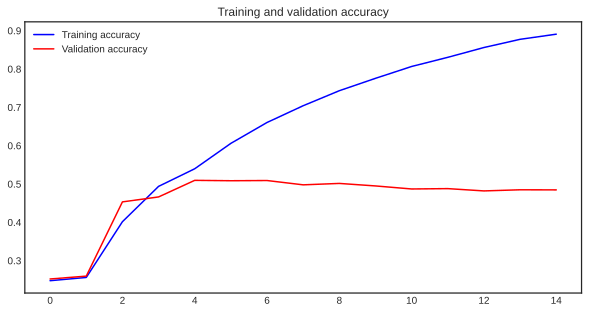

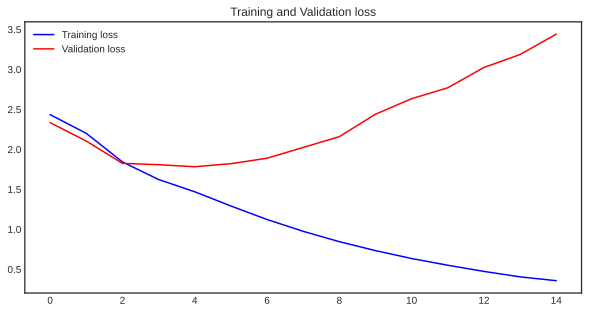

In [60]:
plot_history(history)